# Graph Overflow

Group 5

- Asger Laurits Schultz
- August Semrau Andersen
- Andreas Hornemann Nielsen

## Table of contents

- 1. Motivation
- 2. Data
- 3. Analysis
    - 3.1. Stack Overflow as a Graph
    - 3.2. Sentiment Analysis and Loved Languages
    - 3.3. Building a Language Classifier Using TF-IDF
    - 3.4. Using the Classifier to Partition the Graph
- 4. Discussion

## 1. Motivation

### - What is your dataset?
Our dataset consists of 1.3 million submissions, that is questions, answers and comments, publicly available on Stack Overflow.  
These submissions share a few characteristics:
 - They are tagged with one of 16 programming languages.
 - They were submitted earliest 2015 up until now. The data spans this period of time uniformly.
 - The contain (anonomous) id on the user/author of each submission, as well as the parent user/author in the case of answers to uestions or comments to questions or answers.  

### - Why did you choose this/these particular dataset(s)?

### - What was your goal for the end user's experience?

## 2. Data

## - Write about your choices in data cleaning and preprocessing

## - Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

Our data consists of a subset of Stack Overflow threads created from 2015 to 2019.
We have selected the following 16 widely used programming languages to focus on: Rust, TypeScript, Python, Kotlin, Go, Dart, C#, JavaScript, Haskell, Java, C++, Ruby, C, Perl, Objective-C, and VBA.

For each week in the period, we download up to 100 threads for each language including the question itself, all answers, and all comments, as well as information about the authors.
This also means that some of the answers and comments will extend past 2019.
The data is collected using the <a href="https://pypi.org/project/stackapi">StackAPI</a> wrapper for the <a href="https://api.stackexchange.com/">Stack Excange API</a>.
Due to throttling limitations, the data was downloaded over multiple days using the following script.
This should give a representative sample within each language.

In [2]:
%%script false --no-raise-error
from __future__ import annotations
import os
import sys
import datetime as dt
import json
import math
from typing import Any

import click
import pandas as pd
import stackapi
from pelutils import log, Levels
from tqdm import tqdm

# Fetch data from five years
DAY_INTERVAL = 7
START_DATE = dt.datetime(2015, 1, 1)
END_DATE = dt.datetime(2020, 1, 1)

SITE = stackapi.StackAPI("stackoverflow")
SITE.max_pages = 1
N_REQUESTS = math.ceil((END_DATE - START_DATE).days / DAY_INTERVAL)
assert N_REQUESTS < 300

def _get_by_nested_keys(d: dict, keys: list[str]) -> tuple[str, Any]:
    if len(keys) == 1:
        return d.get(keys[0])
    else:
        return _get_by_nested_keys(d[keys[0]], keys[1:])

def get_data(language: str) -> pd.DataFrame:

    os.makedirs(os.path.join("data", language), exist_ok=True)
    log.section("Getting data for %s from %s to %s" % (language, START_DATE.date(), END_DATE.date()-dt.timedelta(days=1)))
    log("Using %i requests" % N_REQUESTS)
    quota_remaing = 300
    questions = list()

    start, end = START_DATE, START_DATE + dt.timedelta(days=DAY_INTERVAL)
    for i in tqdm(range(N_REQUESTS)):
        r = SITE.fetch(
            "questions",
            fromdate=start,
            todate=end,
            tagged=language,
            sort="creation",
            filter="!)PBt)ZX9Bm(JUgw*DM)sjdIE*XsapktUmLzYx2hZO*0Ucza8VQCedEvwmjgs5h_VvaGrwX",
        )
        quota_remaing = r["quota_remaining"]
        questions += r["items"]
        # Save fetched data
        with open(os.path.join("data", language, "response_%i.json" % i), "w") as f:
            json.dump(r["items"], f)

        start += dt.timedelta(days=DAY_INTERVAL)
        end += dt.timedelta(days=DAY_INTERVAL)
        if start >= END_DATE:
            break
        elif end > END_DATE:
            end = END_DATE

    log("Got %i responses" % len(questions), "Remaining quota: %i" % quota_remaing)

    # Save useful things from response
    log.section("Extracting useful data")
    useful_question_keys = { "title", "body", "view_count", "score", "creation_date", "link",
        "question_id", "owner/user_id", "owner/reputation" }
    useful_answer_keys = { "body", "creation_date", "score", "owner/user_id", "owner/reputation", "answer_id" }
    useful_comment_keys = useful_answer_keys
    filtered_questions, filtered_answers, filtered_comments = list(), list(), list()
    for _, q in tqdm(enumerate(questions)):
        filtered_questions.append({
            "language": language,
            **{ key: str(_get_by_nested_keys(q, key.split("/"))) for key in useful_question_keys if key in q or "/" in key }
        })
        for answer in q.get("answers", list()):
            filtered_answers.append({
                "language": language,
                "question_id": str(q["question_id"]),
                **{ key: str(_get_by_nested_keys(answer, key.split("/"))) for key in useful_answer_keys if key in answer or "/" in key }
            })
            for comment in answer.get("comments", list()):
                filtered_comments.append({
                    "language": language,
                    "question_id": str(q["question_id"]),
                    "answer_id": str(answer["answer_id"]),
                    **{ key: str(_get_by_nested_keys(comment, key.split("/"))) for key in useful_comment_keys if key in comment or "/" in key },
                })
        for comment in q.get("comments", list()):
            filtered_comments.append({
                "language": language,
                "question_id": str(q["question_id"]),
                **{ key: str(_get_by_nested_keys(comment, key.split("/"))) for key in useful_comment_keys if key in comment or "/" in key },
            })

    df = pd.DataFrame(filtered_questions)
    q_path = os.path.join("data", language, "questions.pkl")
    df.to_pickle(q_path)
    log("Saved %i questions to %s" % (len(df), q_path))
    del df

    df = pd.DataFrame(filtered_answers)
    a_path = os.path.join("data", language, "answers.pkl")
    df.to_pickle(a_path)
    log("Saved %i answers to %s" % (len(df), a_path))
    del df

    df = pd.DataFrame(filtered_comments)
    c_path = os.path.join("data", language, "comments.pkl")
    df.to_pickle(c_path)
    log("Saved %i comments to %s" % (len(df), c_path))
    del df

@click.command()
@click.argument("language")
def run(language: str):
    path = os.path.join("data", "%s-questions.pkl" % language)
    if os.path.exists(path):
        cont = log.bool_input(log.input("%s eksisterer allerede. Vil du fortsætte alligevel? [j/n] " % path), default=False)
        if not cont:
            sys.exit()
    get_data(language.lower())

if __name__ == "__main__":
    with log.log_errors:
        log.configure("local_data.log", "Fetching data", print_level=Levels.DEBUG)
        run()

The downloaded data is then converted into a single, large dataframe containing all submissions.
Because of the large amount of data, half is removed, as memory would otherwise be a serious constraint.
This is done by thread basis.
Half of all question ID's are randomly selected, and submissions with that ID are removed.

In [1]:
from __future__ import annotations
import os
import pandas as pd
import vaderSentiment.vaderSentiment as vader
import re
from glob import glob as glob  # glob
from tqdm import tqdm
from pelutils import Table, thousand_seps
from pelutils.ds.plot import tab_colours
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from sklearn.metrics import f1_score
import datetime as dt
import itertools
import random
import json
import pickle
import scipy
import networkx as nx
import netwulf as nf
import community as cm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.rc("font", size=16)
mpl.rcParams["font.family"] = "Liberation Serif"
import warnings
warnings.filterwarnings('ignore')

# Selected language and how loved they were according to the 2020 Stack Overflow developer survey
loved_languages = {
    "rust": 86.1, "typescript": 67.1, "python": 66.7, "kotlin": 62.9, "go": 62.3, "dart": 62.1,
    "c#": 59.7, "javascript":  58.3, "haskell": 51.7, "java": 44.1, "c++": 43.4, "ruby": 42.9,
    "c": 33.1, "perl": 28.6, "objective-c": 23.4, "vba": 19.6,
}
# Which colours to use for the different languages
language_colors = {
    "rust": 'peru', "typescript": 'navy', "python": 'cyan', "kotlin": 'azure', "go": 'moccasin', "dart": 'maroon',
    "c#": 'purple', "javascript": 'yellow', "haskell": 'black', "java": 'green', "c++": 'red', "ruby": 'olive',
    "c": 'pink', "perl": 'magenta', "objective-c": 'lime', "vba": 'orange',
}

In [2]:
# Collect all data into single dataframe
qdfs = list()
adfs = list()
cdfs = list()
for lang in tqdm(loved_languages):
    qf = os.path.join("data", lang, "questions.pkl")
    af = os.path.join("data", lang, "answers.pkl")
    cf = os.path.join("data", lang, "comments.pkl")
    qdfs.append(pd.read_pickle(qf))
    qdfs[-1]["language"] = lang
    qdfs[-1]["type"] = "q"
    adfs.append(pd.read_pickle(af))
    adfs[-1]["language"] = lang
    adfs[-1]["type"] = "a"
    cdfs.append(pd.read_pickle(cf))
    cdfs[-1]["language"] = lang
    cdfs[-1]["type"] = "c"

# Shuffle to prevent systematic biases in contiguous subsets of dataframe
so = pd.concat(qdfs + adfs + cdfs, ignore_index=True).sample(frac=1)
del qdfs, adfs, cdfs

# Remove half of data, as there is otherwise too much to handle
qids = { qid for qid in set(so.question_id) if random.random() > 0.5 }
so = so[so.question_id.isin(qids)]
so
# Convert unix timestamps to datetime objects
so["created"] = [dt.datetime.utcfromtimestamp(int(ts)) for ts in so["creation_date"]]
del so["creation_date"]

100%|██████████| 16/16 [00:02<00:00,  6.20it/s]


In [5]:
# Data summary
t = Table()
t.add_header(["Language", "Questions", "Answers", "Comments", "Total"])
for lang in tqdm(loved_languages):
    t.add_row([
        lang.capitalize(),
        *[thousand_seps(sum((so["language"] == lang) & (so["type"] == t))) for t in ("q", "a", "c")],
        thousand_seps(sum(so["language"] == lang)),
    ], [1, 0, 0, 0, 0])
t.add_row([
    "",
    thousand_seps(sum(so["type"] == "q")),
    thousand_seps(sum(so["type"] == "a")),
    thousand_seps(sum(so["type"] == "c")),
    thousand_seps(len(so)),
], [1, 0, 0, 0, 0])
print("Number of submissions in dataset")
print(t)
print("\nNumber of users in dataset")
print(thousand_seps(len(set(so["owner/user_id"]))))

100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


Number of submissions in dataset
Language    | Questions | Answers | Comments | Total    
------------+-----------+---------+----------+----------
Rust        |     6,504 |   7,880 |   25,018 |    39,402
Typescript  |    12,009 |  17,564 |   45,333 |    74,906
Python      |    13,182 |  18,208 |   52,470 |    83,860
Kotlin      |     8,012 |  12,528 |   29,317 |    49,857
Go          |    13,005 |  17,303 |   47,627 |    77,935
Dart        |     6,165 |  10,253 |   21,587 |    38,005
C#          |    13,160 |  16,669 |   60,440 |    90,269
Javascript  |    13,144 |  18,344 |   54,934 |    86,422
Haskell     |    10,886 |  15,109 |   50,379 |    76,374
Java        |    12,995 |  16,968 |   53,930 |    83,893
C++         |    12,994 |  17,498 |   81,129 |   111,621
Ruby        |    12,960 |  17,893 |   52,193 |    83,046
C           |    13,040 |  20,080 |   94,890 |   128,010
Perl        |     9,835 |  15,578 |   55,736 |    81,149
Objective-c |    11,829 |  14,437 |   47,702 |    73,96

With the data nicely collected, we clean it.
As we need it for different purposes, this is done in two different ways for the sentiment analysis and classifier that will be introduced in later sections.
The text bodies are raw HTML, so tags (but not their contents) are removed.
Stopwords and links are also removed.

For the sentiment analysis, we remove all code, as code is not expected to carry sentiment.
This is not done for the classifier, as keywords and naming conventions should provide strong classification features.
However, all non alphanumeric characters are removed, as this is not expected to aid in classification.
These characters are kept for the sentiment analysis, as <a href="https://pypi.org/project/vader-sentiment/">VADER</a>, the used sentiment analysis tool, takes punctuation into account.
For the classifier, we all text is also converted to lower case.

In [6]:
# Regex for matching stopwords
sw = r"\b(" + "|".join(stopwords.words("english")) + r")\b"

def cclean(text: str) -> str:
    """ Cleaning for classification """
    # Remove links
    text = re.sub(r"\bhttp\S+", "", text)
    # Remove stopwords
    text = re.sub(sw, "", text)
    # Remove html tags
    text = re.sub(r"<.*?>", "", text)
    # Remove everything that is not alpha-numeric
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.lower()

def sclean(text: str) -> str:
    """ Cleaning for sentiment analysis """
    # Remove code
    text = re.sub(r"<pre><code>.*<\/pre><\/code>", "", text)
    # Remove links
    text = re.sub(r"\bhttp\S+", "", text)
    # Remove stopwords
    text = re.sub(sw, "", text)
    # Remove html tags
    text = re.sub(r"<.*?>", "", text)
    return text

words = sum(len(body.split()) for body in so.body)
chars = sum(len(body) for body in so.body)
print("Before cleaning")
print("  Words:               %s" % thousand_seps(words))
print("  Avg. per submission: %.2f" % (words / len(so)))
print("  Characters:          %s" % thousand_seps(chars))
print("  Avg. per submission: %.2f" % (chars / len(so)))

print("\nCleaning text for classification")
so["cclean"] = [cclean(body) for body in tqdm(so.body)]

words = sum(len(body.split()) for body in so.cclean)
chars = sum(len(body) for body in so.cclean)
print("\nAfter cleaning for classification")
print("  Words:               %s" % thousand_seps(words))
print("  Avg. per submission: %.2f" % (words / len(so)))
print("  Characters:          %s" % thousand_seps(chars))
print("  Avg. per submission: %.2f" % (chars / len(so)))

print("\nCleaning text for sentiment analysis")
so["sclean"] = [sclean(body) for body in tqdm(so.body)]

words = sum(len(body.split()) for body in so.sclean)
chars = sum(len(body) for body in so.sclean)
print("\nAfter cleaning for classification")
print("  Words:               %s" % thousand_seps(words))
print("  Avg. per submission: %.2f" % (words / len(so)))
print("  Characters:          %s" % thousand_seps(chars))
print("  Avg. per submission: %.2f" % (chars / len(so)))

# Save prepared data for later use
so.to_pickle("data.pkl")

  0%|          | 954/1271684 [00:00<02:13, 9484.07it/s]

Before cleaning
  Words:               86,022,245
  Avg. per submission: 67.64
  Characters:          703,044,291
  Avg. per submission: 552.85

Cleaning text for classification


  0%|          | 1141/1271684 [00:00<01:51, 11407.45it/s]


After cleaning for classification
  Words:               51,489,191
  Avg. per submission: 40.49
  Characters:          472,213,883
  Avg. per submission: 371.33

Cleaning text for sentiment analysis


100%|██████████| 1271684/1271684 [01:47<00:00, 11853.82it/s]



After cleaning for classification
  Words:               58,541,043
  Avg. per submission: 46.03
  Characters:          529,165,009
  Avg. per submission: 416.11


In [2]:
if "so" not in locals():
    so = pd.read_pickle("data.pkl")
so

,language,owner/reputation,title,view_count,question_id,owner/user_id,link,score,body,type,answer_id,created,cclean,sclean
2330461,objective-c,3258,NaN,NaN,31828857,1085848,NaN,1,why touchesBegan will have delay? anyway to sp...,c,31829331,2015-11-16 03:09:29,touchesbegan delay anyway speed,touchesBegan delay? anyway speed ?
529160,dart,11,NaN,NaN,57275594,12212650,NaN,1,<p>In this case <code>context</code> does not ...,a,65773729,2021-01-18 11:31:48,in case context include provider so ach...,In case context include provider. So ac...
1611028,haskell,100185,NaN,NaN,49335008,3234959,NaN,1,But your definition above does not make all br...,c,NaN,2018-03-17 11:18:39,but definition make branches depth eg...,"But definition make branches depth, e..."
379856,rust,46,NaN,NaN,57633089,11963700,NaN,1,"<p>As mcarton said, the vector needs to be sor...",a,57633379,2019-08-23 21:49:02,as mcarton said vector needs sorted bi...,"As mcarton said, vector needs sorted b..."
1004789,typescript,59546,NaN,NaN,57793278,6294072,NaN,1,I suggest you take a thorough read of the docu...,c,NaN,2019-09-04 18:14:24,i suggest take thorough read documentation...,I suggest take thorough read documentation...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673357,java,110342,NaN,NaN,37712402,1441122,NaN,2,@Jean-Fran&#231;oisSavard A pure function prod...,c,37738053,2016-07-09 00:49:59,jeanfran231oissavard a pure function produces ...,@Jean-Fran&#231;oisSavard A pure function prod...
655380,java,71,NaN,NaN,50380810,9767930,NaN,0,<p>I would try splitting the string at the fil...,a,50381732,2018-05-17 00:30:47,i would try splitting string file separator...,I would try splitting string file separator...
84846,go,37,I want to know the pattern and logic in this code,54,35257888,5895067,https://stackoverflow.com/questions/35257888/i...,-3,<p>i am new to Go so i need to know the patter...,q,NaN,2016-02-07 19:15:32,new go need know pattern understand l...,new Go need know pattern understand l...
2198669,c,78982,NaN,NaN,58091602,1848654,NaN,1,"<code>pipeArr</code> is not an array, it is a ...",c,NaN,2019-09-25 05:21:48,pipearr array pointer,"pipeArr array, pointer."


With the data cleaned, let's understand it better. First we look at the distribution of submission sizes, and how the cleaning affected it.

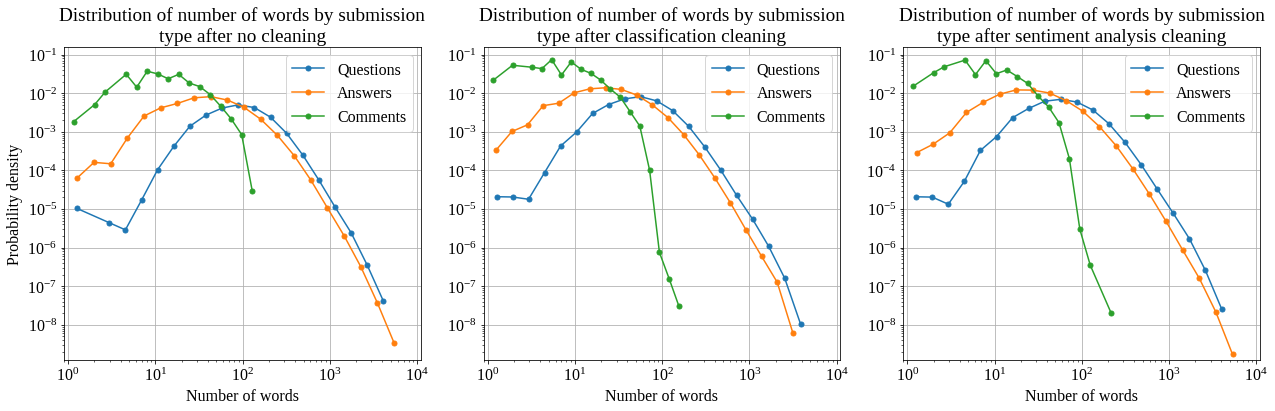

In [9]:
def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):
    """ Bins data accourding to spacing function and number of given bins """
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, (lab, dat) in enumerate(zip(("No cleaning", "Classification cleaning", "Sentiment analysis cleaning"), (so.body, so.cclean, so.sclean))):
    ax_ = axs[i]
    # Plot distribution of words
    qx, qdist = bins(np.array([len(text.split()) for text in dat[so.type=="q"]]))
    ax, adist = bins(np.array([len(text.split()) for text in dat[so.type=="a"]]))
    cx, cdist = bins(np.array([len(text.split()) for text in dat[so.type=="c"]]))
    with open(os.path.join("data", lab.replace(" ", "") + ".json"), "w") as f:
        json.dump({
            "qx": qx.tolist(),
            "qdist": qdist.tolist(),
            "ax": ax.tolist(),
            "adist": adist.tolist(),
            "cx": cx.tolist(),
            "cdist": cdist.tolist(),
        }, f)

    ax_.plot(qx, qdist, marker=".", ms=10, label="Questions")
    ax_.plot(ax, adist, marker=".", ms=10, label="Answers")
    ax_.plot(cx, cdist, marker=".", ms=10, label="Comments")
    ax_.grid()
    ax_.set_xscale("log")
    ax_.set_yscale("log")
    ax_.set_title("Distribution of number of words by submission\ntype after %s" % lab.lower())
    ax_.set_xlim([0.9, 1.1*10**4])
    ax_.set_ylim([10**-8.9, 10**-0.8])
    ax_.set_xlabel("Number of words")
    if i == 0:
        ax_.set_ylabel("Probability density")
    ax_.legend(loc=1)
plt.tight_layout()
plt.show()

<strong>TODO: Comment on figures and probably more figures</strong>

# 3. Analysis

## - Talk about how you've worked with text, including regular expressions, unicode, etc.

## - Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

## - How did you use the tools to understand your dataset?

### 3.1. Stack Overflow as a Graph

The content on Stack Overflow can naturally be understood as a network in which the individual users are linked by the interactions they make.  
The data can hereby be modelled as a directed, weighted graph, in which each node is a unique user on Stack Overflow, and each edge is an interaction between a pair of users, this being a user answering a question asked by another user,or commenting on either a question or an answer by another user. 
The associated weight is the number of times these users have interacted.  

In order to get an in-depth look at the data, we will create graphs for each network made up of single programming languages first, and then of the entire Stack Overflow network.
This way, we can see if there are standout-features of any of the programming languages when compared to each other


NetworkX, a python package encountered in the course, is used for creating the Stack Overflow network graph as it gives the ability to create a wide range of graph types, and in our case importantly to create big, complex graphs while not sacrificing computation speed.

Some notes about the Stack Overflow network graph creation:  
1. During the creation of the graph, a lot of potential edges are filtered, and this is because:
 - There are many questions which naturally do not have any parent-author, and would create a self-loop (which we are not interested in keeping trakc of).
 - A lot of especially comments, but also answers, are interacting with a question_id or answer_id which is not contained ibn the data, and can therefor not be mapped to a parent-author. This is natural, as the solution to this issue would be to be in possesion of *all* data, which is not feasible.

2. The network is ideally graphed as a directed, weighted graph, as all interactions happen one-way (until a recipent of an answer or comment comments back).
The function though also contains the ability to create an undirected graph, which will be utilized when computing modularity and using the Louvain algorithm.

3. For each user, the programming language(s) they have made a submission on is saved as node attribute with an associated weight counting the number of times this has happened. 
Some users have made submissions on more than one programming language, and these are the users who bind together the different programming languages in the Stack Overflow network graph. 
The programming language with the highest weight is deemed a user's top language, and is what we use for partitioning the big graph into programming language specific communities.

In [16]:
### This cell contains the function for creating the big Stack Overflow network graph
def so_network(so_data, directed=True):

    ## Get Questions, answers and comments seperately
    questions = so_data.loc[so_data['type'] == 'q']
    answers = so_data.loc[so_data['type'] == 'a']
    comments = so_data.loc[so_data['type'] == 'c']
    print(questions.shape)
    print(answers.shape)
    print(comments.shape)

    ## Get authors of questions and answers
    question_authors = dict(zip(questions['question_id'], questions['owner/user_id']))
    answer_authors = dict(zip(answers['answer_id'], answers['owner/user_id']))

    ## Find parent id's of all datapoints
    so_data['parent_author'] = ""
    for index, row in tqdm(so_data.iterrows()):

        ## If question, no parent author (no self-loops)
        if row['type'] == 'q':  
            so_data.at[index, 'parent_author'] = None

        ## If answer, parent author is author of question answered
        elif row['type'] == 'a':
            try:
                so_data.at[index, 'parent_author'] = question_authors[str(row['question_id'])]
            except: # Parent missing
                so_data.at[index, 'parent_author'] = None
        
        ## If comment, parent author is either author of commented question or answer
        else:
            try:  # Commenting on an answer
                so_data.at[index, 'parent_author'] = answer_authors[str(row['answer_id'])]
            except:
                try:  # Commenting on a question
                    so_data.at[index, 'parent_author'] = question_authors[str(row['question_id'])]
                except:  # Parent missing
                    so_data.at[index, 'parent_author'] = None

    ## Filter for NANs, there are a lot for comments..
    print('Stack Overflow data before filtering for NANs', so_data.shape)
    so_data = so_data[so_data['parent_author'].notnull()]
    so_data = so_data[so_data['owner/user_id'].notnull()]
    so_data = so_data[so_data['parent_author'] != 'None']
    so_data = so_data[so_data['owner/user_id'] != 'None']
    so_data = so_data[so_data['owner/user_id'] != so_data['parent_author']]
    print('Stack Overflow data after filtering for NANs', so_data.shape)

    ## Create weighted edge list for all sets of source, target and programming language
    edge_list = so_data.groupby(['owner/user_id', 'parent_author', 'language']).size().to_frame('weight').reset_index()

    ## Make language and weight info-dict
    edge_list['language_weight'] = edge_list.apply(lambda row: {row['language']:row['weight']}, axis=1)

    print('Edge list before accomodating for bilingual source-target pairs', edge_list.shape)

    ## Find duplicates, ie. source-target pairs interacting on 2 or more different prog. languages
    bilinguals = edge_list[edge_list.duplicated(['owner/user_id', 'parent_author'], keep=False)]
    bilinguals_last = bilinguals[bilinguals.duplicated(['owner/user_id', 'parent_author'], keep='first')]

    ## Drop duplicates keeping first instance
    edge_list = edge_list.drop_duplicates(['owner/user_id', 'parent_author'], keep='first')

    ## Add the duplicates' language-weight data to the first instance of the interaction
    print(bilinguals_last.shape)
    for _, row in tqdm(bilinguals_last.iterrows()):
        index = edge_list.index[(edge_list['owner/user_id'] == row['owner/user_id']) & (edge_list['parent_author'] == row['parent_author'])]
        edge_list.loc[index]['language_weight'].item()[row['language']] = row['weight']

    print('Edge list after accomodating for bilingual interaction pairs', edge_list.shape)

    ## Define nodes and weights
    sources = list(edge_list['owner/user_id'])
    targets = list(edge_list['parent_author'])
    weights = list(edge_list['weight'])
    language_weights = list(edge_list['language_weight'])
    
    ## Create graph, adding nodes and edges
    if directed:
        so_graph = nx.DiGraph()
    else:
        so_graph = nx.Graph()
        
    for i in tqdm(range(len(sources))):
        ## If node not already in graph, we add it, otherwise we add the language weights
        if sources[i] not in so_graph:
            so_graph.add_node(sources[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[sources[i]]['languages']:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[sources[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])
        
        if targets[i] not in so_graph:
            so_graph.add_node(targets[i], languages=language_weights[i], top_language=None)
        else:
            prog_langs = list(language_weights[i].keys())
            prog_lang_weights = list(language_weights[i].values())
            for j in range(len(prog_langs)):
                if str(prog_langs[j]) not in so_graph.nodes[targets[i]]['languages']:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] = int(prog_lang_weights[j])
                else:
                    so_graph.nodes[targets[i]]['languages'][str(prog_langs[j])] += int(prog_lang_weights[j])

        so_graph.add_edge(sources[i], targets[i])#, weight=sum(language_weights[i].values()))

    ## Add  top language as node attribute
    for i in so_graph:
        top_lang = sorted(so_graph.nodes[i]['languages'], key=so_graph.nodes[i]['languages'].get)[-1]
        so_graph.nodes[i]['top_language'] = top_lang
        so_graph.nodes[i]['color'] = language_colors[so_graph.nodes[i]['top_language']]

    return so_graph


### This code creates the Stack Overflow graph, both directed and undirected, and saves as pickle
so_graph = so_network(so_data=so, directed=True)
path = 'so_graph.pkl'
nx.write_gpickle(so_graph, path)

so_undirected_graph = so_network(so_data=so, directed=False)
path = 'so_undirected_graph.pkl'
nx.write_gpickle(so_undirected_graph, path)

1271684it [01:52, 11314.64it/s]


Stack Overflow data before filtering for NANs (1271684, 15)
Stack Overflow data after filtering for NANs (1253720, 15)


0it [00:00, ?it/s]

Edge list before accomodating for bilingual source-target pairs (273082, 5)


45587it [25:34, 29.72it/s]
 14%|█▍        | 31977/227495 [00:00<00:01, 161554.06it/s]

Edge list after accomodating for bilingual interaction pairs (227495, 5)


100%|██████████| 227495/227495 [00:01<00:00, 134715.16it/s]
1271684it [01:53, 11162.48it/s]


Stack Overflow data before filtering for NANs (1271684, 15)
Stack Overflow data after filtering for NANs (1253720, 15)
Edge list before accomodating for bilingual source-target pairs (273082, 5)


45587it [25:31, 29.77it/s]
  8%|▊         | 17831/227495 [00:00<00:01, 178299.97it/s]

Edge list after accomodating for bilingual interaction pairs (227495, 5)


100%|██████████| 227495/227495 [00:01<00:00, 148117.97it/s]


Now we can perform basic network analysis on the Stack Overflow network graph, and further on the individual programming language specific partitions, which we create as subgraphs, as to get a better understanding of the size of these graphs and how they differentiate.

In [2]:
### This cell loads the pickled data, finds partitions based on programming language, then computes and displays graphs basic summary

## Load pickled Stack Overflow graph
so_graph_path = 'so_graph.pkl'
so_graph = nx.read_gpickle(so_graph_path)

## Retrieve the 16 different programming languages as partitions
so_partitions = {prog_lang : [i for i in so_graph if so_graph.nodes[i]["top_language"] == prog_lang] for prog_lang in loved_languages.keys()}

## Now these are all gathered in a dict
graphs = {prog_lang : None for prog_lang in loved_languages.keys()}
for prog_lang in tqdm(graphs.keys()):
    graphs[prog_lang] = so_graph.subgraph(so_partitions[prog_lang])
graphs['stack_overflow'] = so_graph


## Function for computing number of nodes, number of links and density of graph
def basic_graph_analysis(graph):
    num_nodes = graph.number_of_nodes()
    num_links = graph.number_of_edges()
    density = nx.classes.function.density(graph)
    return num_nodes, num_links, round(density, 7)

## Function for computing in- and out-degrees
def graph_degrees(graph):
    in_degrees = list(dict(graph.in_degree()).values())
    out_degrees = list(dict(graph.out_degree()).values())
    return in_degrees, out_degrees

## Table displaying basic metrics
t = Table()
t.add_row(["Language", "Num Nodes", "Num Links", "Density"])
for prog_lang in graphs.keys():
    num_nodes, num_links, density = basic_graph_analysis(graph=graphs[str(prog_lang)])
    t.add_row([prog_lang.capitalize(), num_nodes, num_links, density], [1, 0, 0, 0])

print("Basic statistics Stack Overflow network graph and programming language specific subgraphs")
print(t)

100%|██████████| 16/16 [00:00<00:00, 233.21it/s]
Basic statistics Stack Overflow network graph and programming language specific subgraphs
Language       | Num Nodes | Num Links | Density  
Rust           |      4413 |     12827 | 0.0006588
Typescript     |     17984 |     26490 |  8.19e-05
Python         |     19815 |     29945 |  7.63e-05
Kotlin         |     11213 |     20150 | 0.0001603
Go             |     12713 |     29005 | 0.0001795
Dart           |      7869 |     15294 |  0.000247
C#             |     19145 |     31877 |   8.7e-05
Javascript     |     20563 |     27750 |  6.56e-05
Haskell        |      6287 |     28979 | 0.0007333
Java           |     20358 |     28491 |  6.87e-05
C++            |     15736 |     36557 | 0.0001476
Ruby           |     14300 |     32989 | 0.0001613
C              |     15693 |     42332 | 0.0001719
Perl           |      8219 |     27454 | 0.0004065
Objective-c    |     14703 |     29065 | 0.0001345
Vba            |     13481 |     33356 | 0.00

As is clear on the above table, the number of nodes and edges varies quite a bit for the different programming languages. 
The data collection process did not explicitly bias on the basis of programming popularity or belovedness but did in fact collect different amounts of data for each programming language, and this is what mainly causes the size difference.

We see that the graph densities are very low, which is no suprise given the very large number of nodes. Recall density is given by:
\begin{equation*}
    density(G) = \frac{m}{n \cdot (n-1)}
\end{equation*}
In which n is the number of nodes and m is number of edges, ie. we would need m = $n \cdot (n-1)$ edges for a complete graph with density 1, in the case of Python that would be m = $17336 \cdot (17336-1) = 300,519,560$ edges.

Below, we compute the in- and out-degrees of the big graph and subgraphs.

In [4]:
### This cell computes and displays degree summary
t = Table()
t.add_header(["Language", "Avg in.", "Avg out.", "Median in.", "Median out.", "Max in.", "Max out.", "Min in.", "Min out.", "Mode in.(#)", "Mode out.(#)"])

for prog_lang in graphs.keys():

    ## Get degrees
    in_degrees, out_degrees = graph_degrees(graph=graphs[str(prog_lang)])

    ## Calculate in-statistics
    avg_in = round(np.mean(in_degrees), 6)
    median_in = np.median(in_degrees)
    max_in = max(in_degrees)
    min_in = min(in_degrees)
    mode_in = scipy.stats.mode(in_degrees)

    ## Calculate out-statistics
    avg_out = round(np.mean(out_degrees), 6)
    median_out = np.median(out_degrees)
    max_out = max(out_degrees)
    min_out = min(out_degrees)
    mode_out = scipy.stats.mode(out_degrees)

    ## Add to table
    t.add_row([prog_lang.capitalize(), avg_in, avg_out, median_in, median_out, max_in, max_out, min_in, min_out, f'{int(mode_in[0])} ({int(mode_in[1])})', f'{int(mode_out[0])} ({int(mode_out[1])})'], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

print("Basic degree (in. and out.) analysis for programming language graphs")
print(t)

Basic degree (in. and out.) analysis for programming language graphs
Language       | Avg in.  | Avg out. | Median in. | Median out. | Max in. | Max out. | Min in. | Min out. | Mode in.(#) | Mode out.(#)
---------------+----------+----------+------------+-------------+---------+----------+---------+----------+-------------+-------------
Rust           | 2.906639 | 2.906639 |        2.0 |         1.0 |     651 |     1745 |       0 |        0 |    1 (1139) |     1 (1908)
Typescript     | 1.472976 | 1.472976 |        1.0 |         1.0 |     425 |      591 |       0 |        0 |    0 (7747) |    1 (10226)
Python         | 1.511229 | 1.511229 |        1.0 |         1.0 |      81 |      318 |       0 |        0 |    0 (6928) |    1 (10068)
Kotlin         | 1.797021 | 1.797021 |        1.0 |         1.0 |     150 |      251 |       0 |        0 |    0 (4760) |     1 (6104)
Go             | 2.281523 | 2.281523 |        1.0 |         1.0 |     499 |     1265 |       0 |        0 |    0 (3852) |

The degree table above shows a couple distinct differences between the different programming languages:
 - The max in and out-degrees are significantly larger for several of the smaller programming languages (as well as C), telling the story of single users being more active in the communities of Rust, Go, Dart, Haskell and Perl which does not populate as many users. 
 - 

Below is the in- and out-degrees plotted as histograms for the single programming language partitioned subgraphs.

Created Directory: degreeplots/


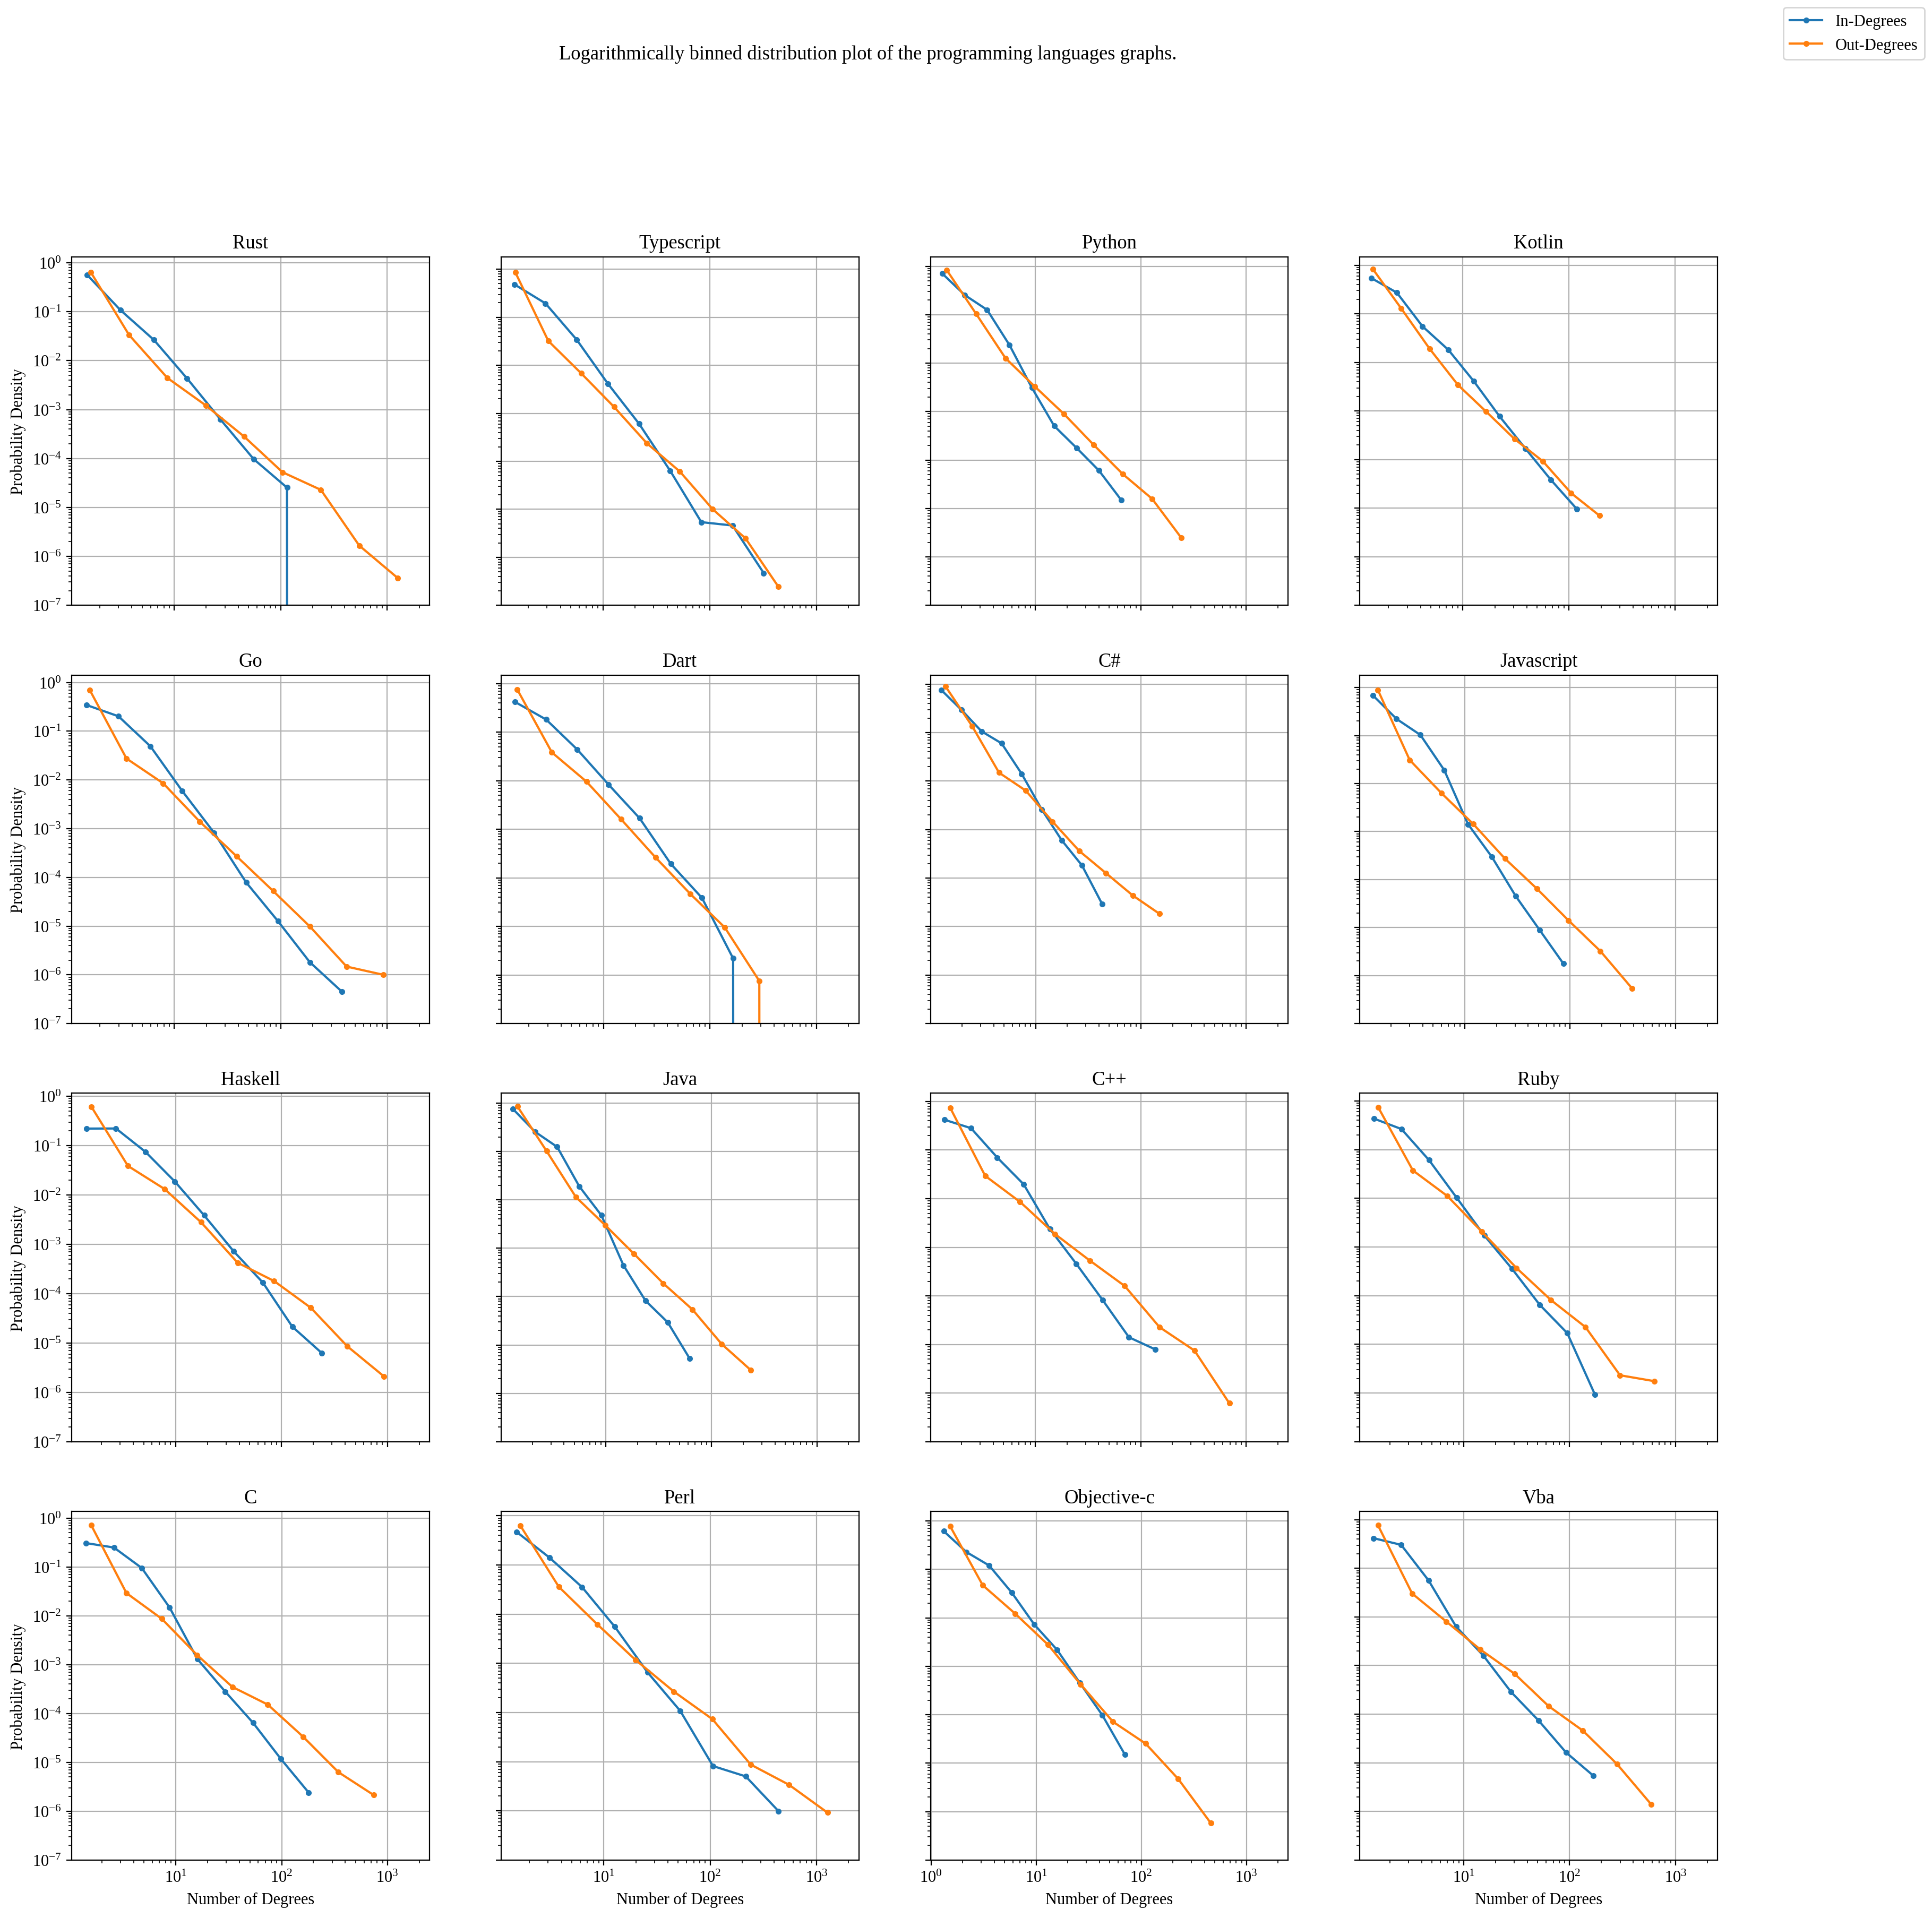

In [5]:
### This cell plots the in-out histograms for the single programming language partitioned subgraphs

## Function for computing histograms
def in_out_degree_histogram(graph):

    in_degrees, out_degrees = graph_degrees(graph)
    bins = np.logspace(0, np.log10(max(in_degrees)), 10)
    in_hist, edges = np.histogram(in_degrees, bins=bins, density=True)
    x_in = (edges[1:] + edges[:-1]) / 2.

    bins = np.logspace(0, np.log10(max(out_degrees)), 10)
    out_hist, edges = np.histogram(out_degrees, bins=bins, density=True)
    x_out = (edges[1:] + edges[:-1]) / 2.
    
    return in_hist, x_in, out_hist, x_out

## Create folder for holding json data for plotting on the webpage
if not os.path.exists('degreeplots/'):
    os.makedirs('degreeplots/')
    print("Created Directory: degreeplots/"),
else:
    print("Directory already existed: degreeplots/" )

## Setup plot settings
def setup_mpl():
    mpl.rcParams['font.family'] = "Liberation Serif"
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (20,20)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

## Create plots
fig, axs = plt.subplots(4,4)
fig.suptitle('Logarithmically binned distribution plot of the programming languages graphs.')

for i in range(4):
    for j in range(4):
        prog_lang = list(graphs.keys())[i*4+j]

        ## Compute histogram
        in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs[str(prog_lang)])
        
        ## We save histogram plot data as json for plotting on the webpage
        path = 'degreeplots/' + str(prog_lang) + '_degreehist.json'
        with open(path, "w") as f:
            json.dump({
                "in_hist": in_hist.tolist(),
                "x_in": x_in.tolist(),
                "out_hist": out_hist.tolist(),
                "x_out": x_out.tolist(),
            }, f)
        
        axs[i,j].plot(x_in, in_hist, marker='.', label='In-Degrees')
        axs[i,j].plot(x_out, out_hist, marker='.', label='Out-Degrees')
        axs[i,j].set_xscale('log')
        axs[i,j].set_yscale('log')
        axs[i,j].set_xlim([np.log10(1), 2.5e3])
        axs[i,j].set_ylim([1e-7, np.log10(1)])
        axs[i,j].set_title(f"{prog_lang.capitalize()}")
        axs[i,j].grid()

## Get labels on legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:2], labels[0:2])

for ax in axs.flat:
    ax.set(xlabel='Number of Degrees', ylabel='Probability Density')
    ax.label_outer()

plt.show()

From the degree plots, we see that the different networks are very similar, though still importantly resemble real, non-random networks.

The entire Stack Overflow network degree distribution can be seen below.

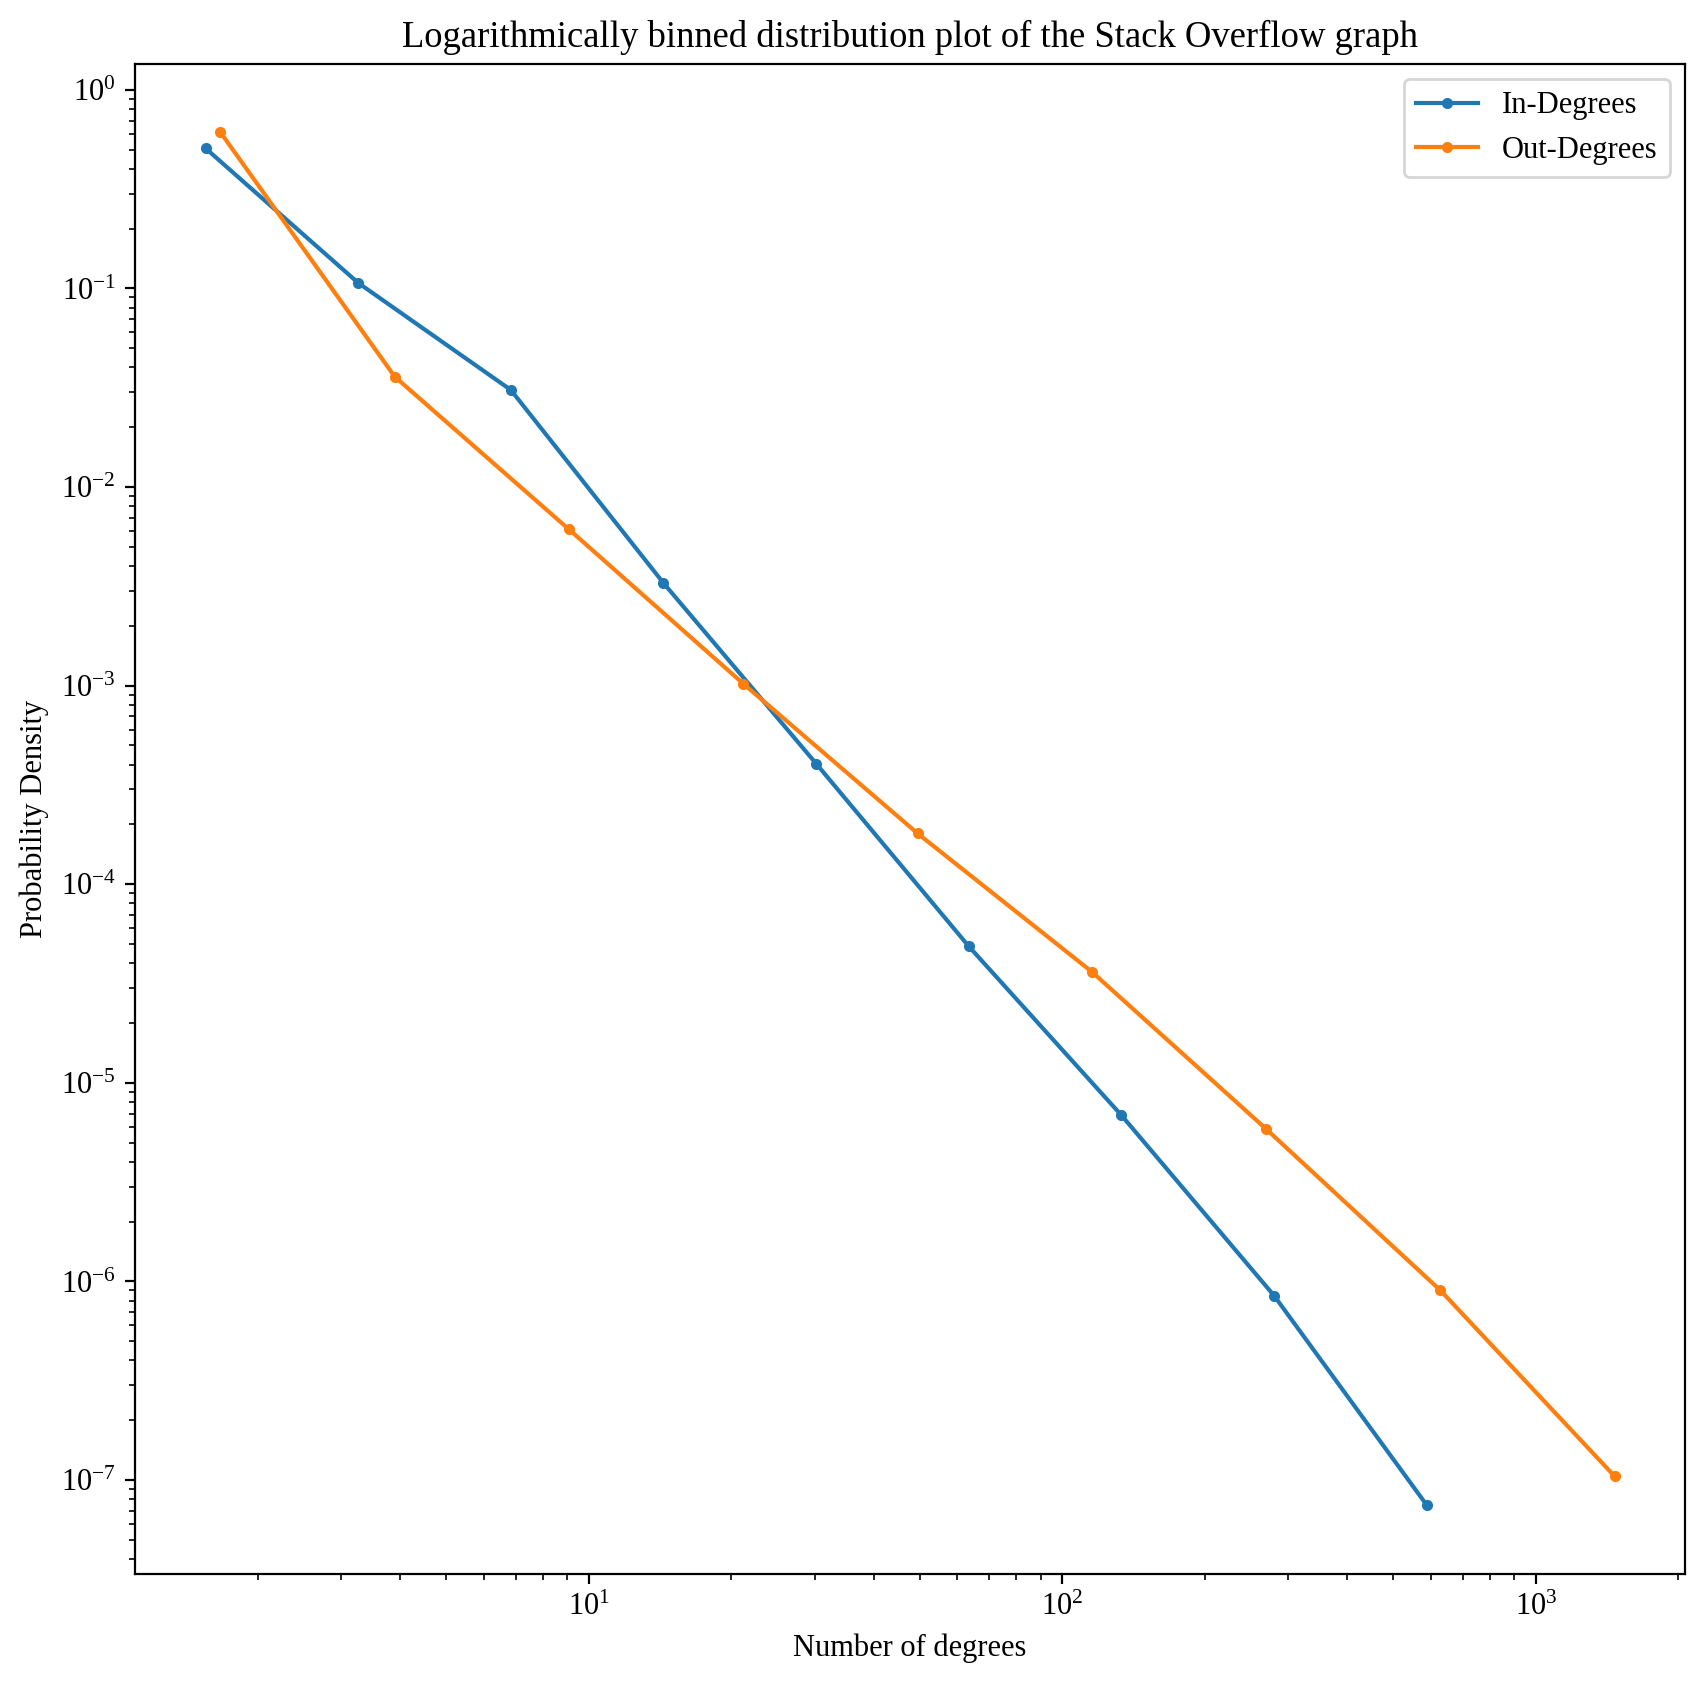

In [6]:
### This cell plots the in-out histogream for the big Stack Overflow network

## Setup plot settings
def setup_mpl():
    mpl.rcParams['font.family'] = "Liberation Serif"
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (10,10)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

## Create plot
fig, ax = plt.subplots()

## Compute histogram
in_hist, x_in, out_hist, x_out = in_out_degree_histogram(graph=graphs['stack_overflow'])

## We save histogram plot data as json for plotting on the webpage
path = 'degreeplots/' + 'so_graph' + '_degreehist.json'
with open(path, "w") as f:
    json.dump({
        "in_hist": in_hist.tolist(),
        "x_in": x_in.tolist(),
        "out_hist": out_hist.tolist(),
        "x_out": x_out.tolist(),
    }, f)

ax.plot(x_in, in_hist, marker='.', label='In-Degrees')
ax.plot(x_out, out_hist, marker='.', label='Out-Degrees')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Stack Overflow')
ax.grid()

ax.set_xlabel('Number of degrees')
ax.set_ylabel('Probability Density')
ax.set_title(f"Logarithmically binned distribution plot of the Stack Overflow graph")
ax.grid()
ax.legend(loc='upper right')

plt.show()


From here, we switch to the undirected graph version of the Stack Overflow network graph, as using a directed graph when computing modularity and using the Louvain algorithm poses trouble.

First we look to compute the modularity of the Stack Overflow network graph, as this is a key indicator of whether the partitions, being the different programming languages, shape the graph such that it is distinct from a random graph.



In [ ]:
### This cell is used for computing the modularity of the Stack Overflow Network

## Load the undirected Stack Oveflow network graph
so_undirected_graph_path = 'graphs/' + 'so_undirected_graph.pkl'
so_undirected_graph = nx.read_gpickle(so_undirected_graph_path)

## Retrieve the 16 different programming languages as partitions
so_undirected_partitions = {prog_lang : [i for i in so_undirected_graph if so_undirected_graph.nodes[i]["top_language"] == prog_lang] for prog_lang in loved_languages.keys()}
# for prog_lang in loved_languages.keys():
#     print(f"{len(so_undirected_partitions[prog_lang])} nodes belong to {prog_lang}")

## Compute modularity using Networkx modularity function
so_undirected_modularity = nx.algorithms.community.modularity(G=so_undirected_graph, communities=so_undirected_partitions.values())
print("Modularity of Stack Overflow programming language splits: %.5f" % so_undirected_modularity)

The modularity found is clearly distinct from zero, but in order to be certain we will utilize a configuration model for generating random counterparts to the Stack Overflow Network graph.  
This is done by making a copy of the graph, and then shuffling all target nodes.
We can then compare the modularity of these to the found modularity.




In [ ]:
### This cell computes the modularity of 100 randomised versions of the undirected Stack Overflow network graph
## Function for creating randomized versions of the Stack Overflow network graph
def conf_model(graph):
    
    ## Create graph that is a copy of nodes
    g = nx.Graph()
    g.add_nodes_from(graph.nodes)
    # g.add_edges_from(graph.edges)
    
    ## Shuffle edge targets and add edges
    sources, targets = np.transpose(graph.edges)
    np.random.shuffle(targets)
    edges = [(source, target) for source, target in np.transpose([sources, targets])]
    # g.remove_edges_from(graph.edges)
    g.add_edges_from(edges)

    return g

random_modularities = [nx.algorithms.community.modularity(G=conf_model(so_undirected_graph), communities=so_undirected_partitions.values()) for _ in tqdm(range(100))]
print("")
print("Average modularity: %.10f" % np.mean(random_modularities))
print("Standard deviation: %.10f" % np.std(random_modularities, ddof=1))

As we can see, these modularities are all very close to zero with a tiny standard deviation, meaning they are completely random.  
In the context of how the randomozed versions of the Stack Overflow network graph are made, this makes sense, as we know there are 16 different communities/partitions, which when shuffled will create much more random versions than had there been only say 3 communities/partitions.  

For the sake of it, the distribution of these modularities are shown below, and seem normally distributed around zero.

In [ ]:
def bins(data, spacing=lambda x, b: np.linspace(0, max(x), b), bins=10):
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy
    
## Use binning function from Part 1
mod, dens = bins(random_modularities, lambda x, b: np.linspace(min(x), max(x), b), bins=10)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(mod, dens, marker=".", ms=10, label="Configuration models")
# ax.axvline(nx.algorithms.community.modularity(G=so_undirected_graph, communities=so_undirected_partitions.values()), c="orange", label="Club network")
ax.grid(True)
ax.set_title("Modularity distribution of configuration models")
ax.set_xlabel("Modularity")
ax.set_ylabel("Probability density")
ax.legend()

As the last step in this network analysis, we use the Louvain algorithm to split the Stack Overflow network into communities.  
Here, the 
This is not supported for directed graphs using Network-x, and we will therefor use the undirected version of the SO network graph, which will suffice.

In [ ]:
### This cell is used for computing the modularity of the Louvain split Stack Overflow network graph

so_undirected_graph_path = 'graphs/' + 'so_undirected_graph.pkl'
so_undirected_graph = nx.read_gpickle(so_undirected_graph_path)

partition = cm.best_partition(so_undirected_graph)
nc = max(partition.values()) + 1
ns = [[] for i in range(nc)]
for i, p in partition.items():
    ns[p].append(i)
print("Modularity according to Louvain algorithm: %.4f" % nx.algorithms.community.modularity(G=so_undirected_graph, communities=ns))
print("Number of partitions: %i" % nc)

Lastly, the Stack Overflow network graph is vizualized using Netwulf, though this is not optimized for big graphs

In [ ]:
### Vizualizing the Stack Overflow network graph

## We will reduce the graph a bit by getting rid of smaller weakly connected components which will float around the main network structue using Netwulff
so_graph_path = 'graphs/' + 'so_graph.pkl'
reduced_so_graph = nx.read_gpickle(so_graph_path)

print('Before reduction')
print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())
#
for component in list(nx.weakly_connected_components(reduced_so_graph)):
    if len(component) < 100:
        for node in component:
            reduced_so_graph.remove_node(node)

print('After reduction')
print(reduced_so_graph.number_of_nodes())
print(reduced_so_graph.number_of_edges())

## Netwulf configuration
nf_config = {
    # Input/output
    'zoom': 0.6,
    # Physics
    'node_charge': -10,
    'node_gravity': 0.1,
    'link_distance': 15,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    # Nodes
    'node_fill_color': '#79aaa0',
    'node_stroke_color': '#555555',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': True,
    'node_size': 50,
    'node_stroke_width': 1,
    'node_size_variation': 0.24,
    # Links
    'link_color': '#7c7c7c',
    'link_width': 2,
    'link_alpha': 0.5,
    'link_width_variation': 0.5,
    # Thresholding
    'display_singleton_nodes': True,
    'min_link_weight_percentile': 0,
    'max_link_weight_percentile': 1}

## Initiate vizualization, this takes at least 10 minutes to fully render
nf.visualize(reduced_so_graph, config=nf_config)



### 3.2. Sentiment Analysis and Loved Languages

Sentiment scores are calculated by VADER as a compound score of positive, negative, and neutral sentiments.

In [10]:
analyzer = vader.SentimentIntensityAnalyzer()
so["compound"] = [analyzer.polarity_scores(body)["compound"] for body in tqdm(so.sclean)]

100%|██████████| 1271684/1271684 [08:06<00:00, 2614.92it/s]


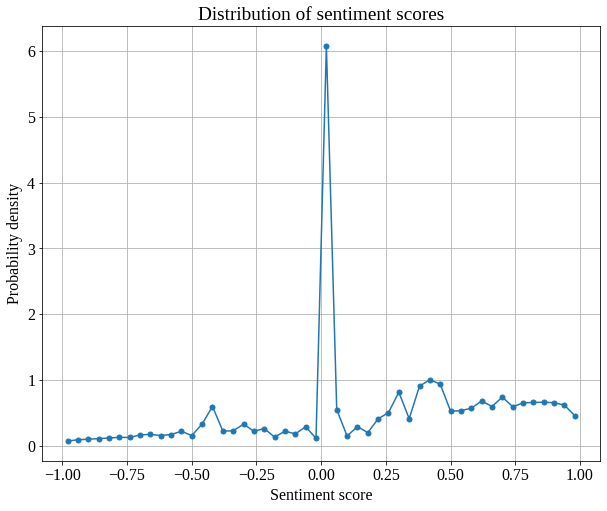

In [11]:
sent, prob = bins(so.compound, lambda x, b: np.linspace(-1, 1, b), bins=50)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(sent, prob, marker=".", ms=10)
ax.set_title("Distribution of sentiment scores")
ax.set_xlabel("Sentiment score")
ax.set_ylabel("Probability density")
ax.grid()

In [12]:
print("Negative (<0): %.2f %%" % (100 * len(so.loc[so.compound<0]) / len(so)))
print("Neutral  (=0): %.2f %%" % (100 * len(so.loc[so.compound==0]) / len(so)))
print("Positive (>0): %.2f %%" % (100 * len(so.loc[so.compound>0]) / len(so)))

Negative (<0): 19.4032 %
Neutral  (=0): 23.7341 %
Positive (>0): 56.8626 %


In [13]:
so.loc[so.compound.isna().values, "compound"] = 0
grouped = so.groupby("language")
mean_sents = grouped.compound.mean()

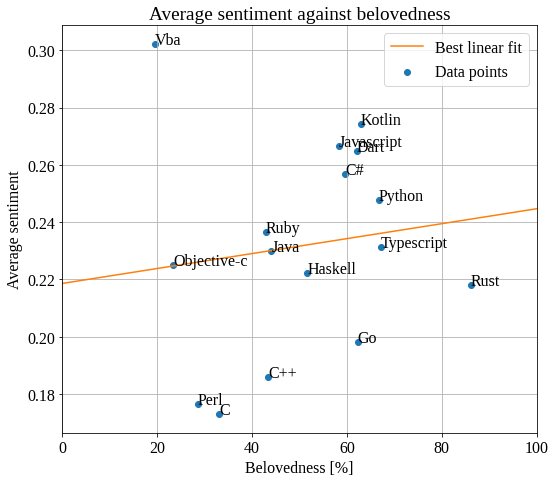

In [14]:
x = np.array(list(loved_languages.values()))
m = np.array([mean_sents[lang] for lang in loved_languages])

plt.figure(figsize=(8, 7))
# Plot means
plt.scatter(x, m, label="Data points")
lm_m = np.polyfit(x, m, 1)
lm_fn = np.poly1d(lm_m)
ends = np.array([0, 100])
plt.plot(ends, lm_fn(ends), c=tab_colours[1], label="Best linear fit")
for i, lang in enumerate(loved_languages):
    plt.annotate(lang.capitalize(), (x[i], m[i]))
plt.title("Average sentiment against belovedness")
plt.xlabel("Belovedness [%]")
plt.ylabel("Average sentiment")
plt.xlim(ends)
plt.grid()
plt.legend()
plt.tight_layout()

with open(os.path.join("data", "sentcorr.json"), "w") as f:
    json.dump({"belovedness": x.tolist(), "mean_sent": m.tolist(), "a": float(lm_m[0]), "b": float(lm_m[1])}, f)

In [15]:
print("Correlation: %.4f" % scipy.stats.pearsonr(x, m)[0])

Correlation: 0.1302


A weak, positive correlation between the belovedness of the languages and the average sentiment.
However, VBA is a clear outlier as both the least beloved language but also the one with the highest average sentiment.
Without this outlier, the correlation would be much stronger.

It should be noted that the belovedness of the languages were taken from 2020 Stack Overflow Developer Survey, which was conducted in <a href="https://insights.stackoverflow.com/survey/2020">February 2020</a>, while the sentiment analysis.
To make sure no temporal biases exist, the average sentiments are plotted over time.

100%|██████████| 16/16 [00:02<00:00,  5.52it/s]


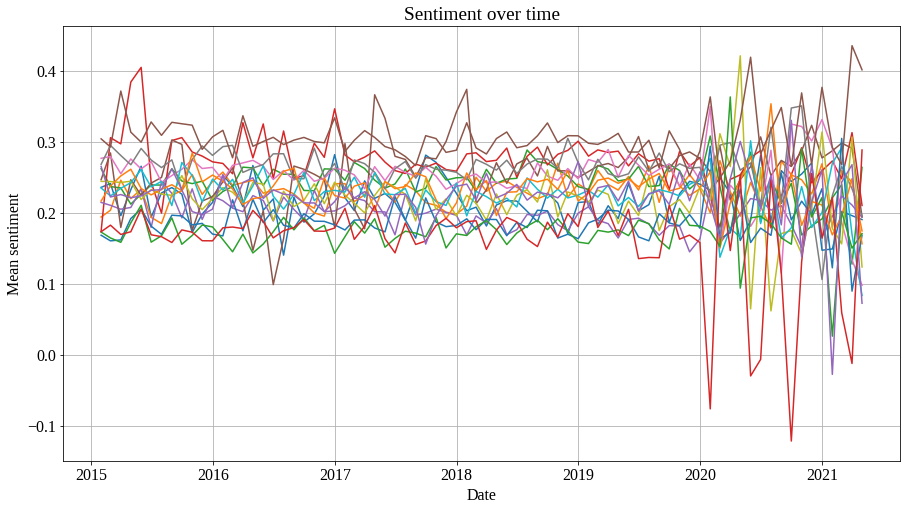

In [16]:
plt.figure(figsize=(15, 8))
for lang in tqdm(loved_languages):
    sub = so.loc[so.language==lang].set_index("created")
    plt.plot(sub.resample("1M")["compound"].mean(), label=lang.capitalize())
plt.xlabel("Date")
plt.ylabel("Mean sentiment")
plt.title("Sentiment over time")
plt.grid()
plt.show()

### 3.3. Building a Language Classifier

TF-IDF is a method for ranking the importance of words in a document. While it is not a common usecase, it is simple to extend this importance ranking into a language classifier.

We work with 16 different programming languages, so we consider 16 documents, each containing the bodies of all questions, answers, and comments from SO threads tagged with the language. First, the data is organized by question ID.
In order to test our classifier, we split each document into a training and a validation document, with the training one containing the text of submissions from 90 % of the threads.

The training set is a large document containing the text from all submissions with the given language.
The validation set is instead split by threads, such that validation is performed based on all submissions in a given thread.

In [7]:
# Build lookup table to get all submissions with given question ID
subs_by_id = defaultdict(list)
for _, row in tqdm(so.iterrows(), total=len(so)):
    subs_by_id[row.question_id].append(row)
subs_by_id = { question_id: pd.DataFrame(rows) for question_id, rows in tqdm(subs_by_id.items()) }

100%|██████████| 180783/180783 [03:45<00:00, 801.74it/s]


In [8]:
train_format = os.path.join("data", "local_train_%s.txt")
val_format = os.path.join("data", "local_val_%s.txt")

# Combine texts by programming language and split into train and validation
train_validation_split = 0.9
n_train_qs = int(train_validation_split * len(subs_by_id))
q_ids = list(subs_by_id)
q_ids_train = set(q_ids[:n_train_qs])

keys = list(subs_by_id)
for lang in loved_languages:
    try:
        os.remove(train_format % lang)
        os.remove(val_format % lang)
    except FileNotFoundError:
        pass
for i, qid in tqdm(enumerate(keys), total=len(subs_by_id)):
    subs = subs_by_id[qid]
    lang = subs.iloc[0].language
    if lang not in loved_languages:
        continue
    if qid in q_ids_train:
        with open(train_format % lang, "a") as ftrain:
            ftrain.write(" ".join(itertools.chain(*(b.split() for b in subs.cclean))) + " ")
    else:
        with open(val_format % lang, "a") as fval:
            fval.write(" ".join(itertools.chain(*(b.split() for b in subs.cclean))) + "\n")
    del subs_by_id[qid]  # No longer needed, so clear from memory
del subs_by_id

train_texts = dict()
val_texts = dict()
for lang in tqdm(loved_languages):
    with open(train_format % lang) as f:
        train_texts[lang] = f.read().split()
    with open(val_format % lang) as f:
        val_texts[lang] = [words.split() for words in f.read().split("\n")]

100%|██████████| 16/16 [00:03<00:00,  4.36it/s]


Text(0, 0.5, 'Number of words')

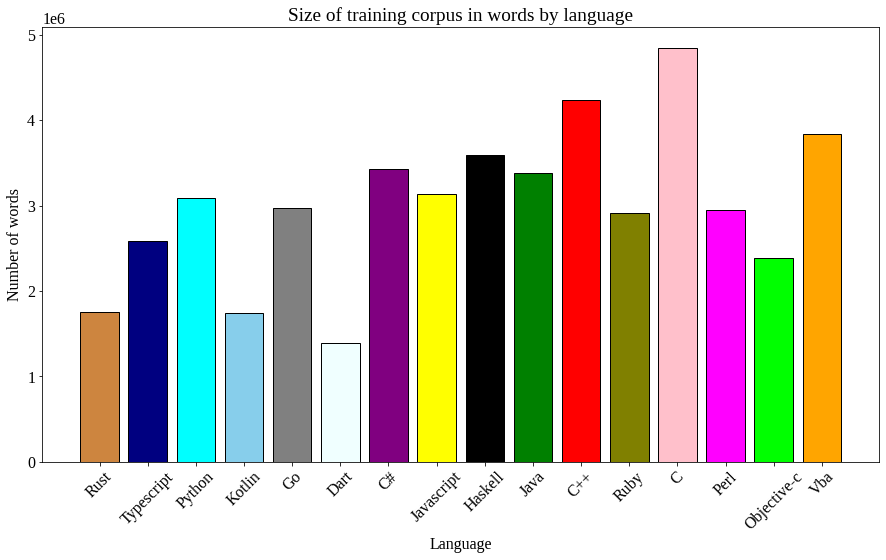

In [12]:
# Corpus size distribution
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.bar(
    range(len(loved_languages)),
    [len(corpus) for corpus in train_texts.values()],
    tick_label=[x.capitalize() for x in train_texts],
    color=language_colors.values(),
    edgecolor="black",
)
ax.tick_params(axis="x", rotation=45)
ax.set_title("Size of training corpus in words by language")
ax.set_xlabel("Language")
ax.set_ylabel("Number of words")

With the data split into training and validation, the classifier can be constructed.
The training consists of building a vocabulary $v$ that maps words to TF-IDF scores for each training document.
Then, given a cleaned text, the classifier calculates a score $S_l$ for each language $l$ using the formula
\begin{equation*}
    S_l=\sum_{\text{word}\,\in\,\text{text}} \begin{cases}
        v_l(\text{word}) &\text{if word}\in v_l\\
        0 &\text{otherwise}
    \end{cases}
\end{equation*}
The language $l^*$ that maximizes $S_l$ is then predicted:
\begin{equation*}
    l^* = \mathop{\operatorname{argmax}}\limits_{l\,\in\,\text{languages}} S_l
\end{equation*}
All $v_l$ are constructed as a dictionary of dictionaries - `tfidf` in the code. This dictionary maps languages to their corresponding $v_l$, which again is a dictionary that maps words to TF-IDF values.

In [27]:
# Build classifier using TF-IDF
tfidf = dict()  # { language: { word: TF-IDF score } }
counts = { lang: Counter(train_texts[lang]) for lang in tqdm(loved_languages) }
t = Table()
t.add_header(["Language", "Size of vocabulary"])
for lang in tqdm(loved_languages):
    # Count of each for given language
    c = counts[lang]
    # Calculate TF and IDF
    tf = { word: count / len(train_texts[lang]) for word, count in c.items() }
    idf = {
        word: np.log(
            len(c) /\
            (1 + sum(word in vocab for vocab in counts.values()))
        )
        for word in c
    }
    tfidf[lang] = { word: tf[word] * idf[word] for word in c }
    t.add_row([lang.capitalize(), thousand_seps(len(tfidf[lang]))], [1, 0])
print(t)

100%|██████████| 16/16 [00:19<00:00,  1.22s/it]

Language    | Size of vocabulary
------------+-------------------
Rust        |            120,382
Typescript  |            205,919
Python      |            290,888
Kotlin      |            171,892
Go          |            213,755
Dart        |            110,469
C#          |            290,316
Javascript  |            277,468
Haskell     |            125,648
Java        |            312,160
C++         |            290,116
Ruby        |            231,602
C           |            283,524
Perl        |            195,391
Objective-c |            203,283
Vba         |            232,496


With the vocabularies constructed, the classifier is ready to be evaluated.
These vocabularies are quite large, so in the interest of limiting memory usage, only a subset of them can be used.
This is done by reducing each $v_l$ to only those words that have the $k$ highest scores.
The classifier is validated on the validation set using all $k\in\{1, 10, 10^2, 10^3, 10^4, 10^5\}$.
We use both raw accuracy and weighted F1 for measuring classification accuracies.

In [3]:
def classify(text: str, cleaned=True, tfidf_: dict=None) -> tuple[str, dict]:
    """
    Classify text by TF-IDF scores by summing TF-IDF for every word in every language and selecting language with highest score
    Returns language and probability distribution over all languages
    An optional TF-IDF dict can be given. Default is the tfidf variable
    """
    tfidf_ = tfidf_ or tfidf
    # Make sure text is cleaned
    if not cleaned:
        text = clean(text)
    word_counts = Counter(text.split())
    scores = dict()
    langs = list(tfidf_.keys())
    for lang, word_tfidf in tfidf_.items():
        scores[lang] = 0
        for word, count in word_counts.items():
            scores[lang] += word_tfidf.get(word, 0)
        if scores[lang] == 0:
            scores[lang] = -float("inf")
    # Calculate probability distribution using softmax
    prob = scipy.special.softmax(np.array(list(scores.values())))
    if np.any(np.isnan(prob)):  # In case of no known words
        return None, None
    return langs[prob.argmax()], prob

def top(counts: dict, n: int) -> dict:
    """ Takes a dict { key: count } and returns a dict with the n key-count pairs with highest counts """
    n_highest = sorted(counts.values())[-n] if n <= len(counts) else min(counts.values())
    return { key: count for key, count in counts.items() if count >= n_highest }

def get_conf_mat(tfidf_: dict=None):
    """ Get confusion matrix over threads using a given tfidf dict """
    conf_mat = np.zeros((len(loved_languages), len(loved_languages)), dtype=int)
    lang_indices = { lang: i for i, lang in enumerate(loved_languages) }
    for lang, i in lang_indices.items():
        texts = val_texts[lang]
        for words in texts:
            pred, _ = classify(" ".join(words), tfidf_=tfidf_)
            if pred is not None:
                conf_mat[lang_indices[pred], i] += 1
    return conf_mat

def f1(conf_mat: np.ndarray) -> float:
    """ Calculate weighted f1 score for a given confusion matrix """
    per_class = conf_mat.sum(axis=0)  # Number of submissions by class
    # Generate fake true and pred vectors that satisfy conf mat to calculate f1 score
    y_true = np.array(list(itertools.chain(*([i]*per_class[i] for i in range(len(conf_mat))))))
    y_pred = np.zeros_like(y_true)
    idx = 0
    for i in range(len(conf_mat)):  # True class
        for j in range(len(conf_mat)):  # Predicted class
            y_pred[idx:idx+conf_mat[j, i]] = j
            idx += conf_mat[j, i]
    return f1_score(y_true, y_pred, average="weighted")

100%|██████████| 6/6 [01:03<00:00, 10.57s/it]


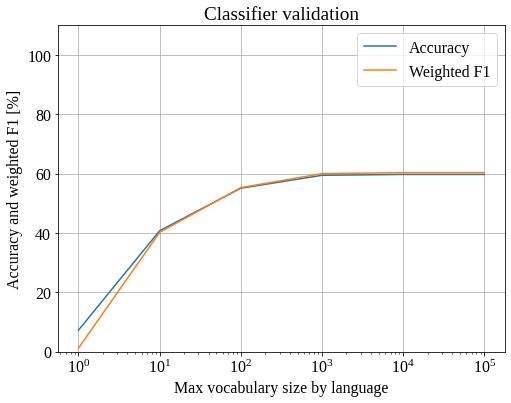

In [31]:
# Get prediction accuracy and weighted f1 for differect vocab sizes
n = 6
number_of_words = np.logspace(0, n-1, n, dtype=int)
accs = list()
f1s = list()
for n_words in tqdm(number_of_words):
    tfidf_ = { lang: top(tfidf[lang], n_words) for lang in tfidf }
    conf_mat = get_conf_mat(tfidf_)
    acc = np.diagonal(conf_mat).sum() / conf_mat.sum()
    accs.append(acc)
    f1s.append(f1(conf_mat))
plt.figure(figsize=(8, 6))
plt.plot(number_of_words, 100*np.array(accs), label="Accuracy")
plt.plot(number_of_words, 100*np.array(f1s), label="Weighted F1")
plt.xticks(number_of_words)
plt.ylim([0, 110])
plt.xscale("log")
plt.grid()
plt.title("Classifier validation")
plt.xlabel("Max vocabulary size by language")
plt.ylabel("Accuracy and weighted F1 [%]")
plt.legend()
with open(os.path.join("data", "accs_f1.json"), "w") as f:
    json.dump({
        "number_of_words": number_of_words.tolist(),
        "accs": accs,
        "f1s": f1s,
    }, f)

Given the results, we keep only the 10,000 highest scored words in each vocabulary.

The below confusion matrix shows the distribution of predictions vs true languages given the aforementioned vocabulary size limit.

In [34]:
# Only save for 10k vocab size, as more is redundant
tfidf = { lang: top(tfidf[lang], 10**4) for lang in tfidf }
with open(os.path.join("data", "tfidf.json"), "w", encoding="utf-8") as f:
    json.dump(tfidf, f)

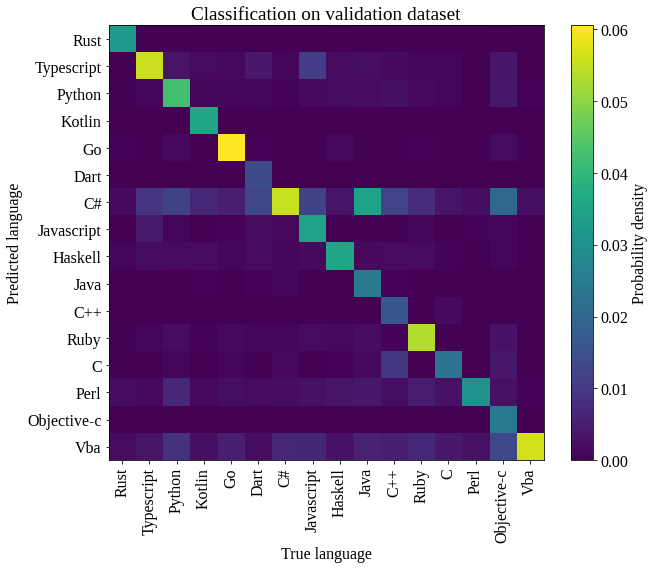

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
pos = ax.imshow(conf_mat/conf_mat.sum())
ax.set_xticks(range(len(loved_languages)))
ax.set_xticklabels([lang.capitalize() for lang in loved_languages])
ax.set_yticks(range(len(loved_languages)))
ax.set_yticklabels([lang.capitalize() for lang in loved_languages])
ax.set_title("Classification on validation dataset")
ax.set_xlabel("True language")
ax.set_ylabel("Predicted language")
ax.tick_params(axis="x", rotation=90)
bar = fig.colorbar(pos)
bar.set_label("Probability density")

### 3.4. Using the Classifier to Partition the Graph

Another way to determine how well the classifier works is within the context of the Stack Overflow graph.
This is done by classifying all nodes (which are authors) by all their submitted content.
Then the modularity is measured.

First a lookup table is constructed that maps users to all their submitted, cleaned content, which has been combined into a single string with different submissions being joined by spaces.

In [5]:
# Load TF-IDF scores
if "tfidf" not in locals():
    with open(os.path.join("data", "tfidf.json")) as f:
        tfidf = json.load(f)
# Load undirected graph
if "so_undirected_graph" not in locals():
    so_undirected_graph = nx.read_gpickle(os.path.join("graphs", "so_undirected_graph.pkl"))

# For every user, combine all their submissions into a single string
subs_by_user = dict()
for user_id, row in tqdm(so.groupby("owner/user_id"), total=len(set(so["owner/user_id"]))):
    subs_by_user[user_id] = " ".join(row.cclean.values)

100%|██████████| 227496/227496 [00:25<00:00, 8777.45it/s] 


In [9]:
# Perform classifications and save in dict that maps user ids to classifications
classifications = { uid: classify(text)[0] for uid, text in tqdm(subs_by_user.items()) }

100%|██████████| 226103/226103 [01:41<00:00, 2222.88it/s]
